# Data Cleaning, Feature Engineering, and Exploratory Data Analysis

In [161]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Load the Dataset

In [162]:
file_path = "./data/gov/transactions_with_interest_final.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,כתובת,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל
0,חטיבת כרמלי 21,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0450
1,חטיבת כרמלי 21,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0025
2,יד לבנים 7,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,לא ידוע,1940.0,3.0,נווה פז,0.0450
3,יד לבנים 37,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,ראשונה,1960.0,3.0,נווה פז,0.0450
4,נווה גנים 4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,קומה 3,2015.0,8.0,נווה פז,0.0450


## Identify Missing Values

In [163]:
# Define custom missing value conditions
df['שנת בנייה'] = df['שנת בנייה'].replace(0, pd.NA)
df['קומות במבנה'] = df['קומות במבנה'].replace(0, pd.NA)
df['קומה'] = df['קומה'].replace('-', pd.NA)
df['קומה'] = df['קומה'].replace('לא ידוע', pd.NA)
df['חדרים'] = df['חדרים'].replace('לא ידוע', pd.NA)
df['סוג נכס'] = df['סוג נכס'].replace('לא ידוע', pd.NA)
df['מ"ר'] = df['מ"ר'].replace('לא ידוע', pd.NA)
df['כתובת'] = df['כתובת'].replace('ללא כתובת', pd.NA)

# Count missing values per column
missing_counts = df.isna().sum()
missing_counts

כתובת               3690
מ"ר                  338
תאריך עסקה             0
מחיר                   0
גוש/חלקה/תת-חלקה       0
סוג נכס             2137
חדרים               2531
קומה                2966
שנת בנייה           4678
קומות במבנה         6330
שכונה                  0
ריבית בנק ישראל        0
dtype: int64

## Handle Missing Values

For each of these fields, we will use an approach that suits its importance to the model and the amount of missing data.

For the street name feature, we chose to fill missing values as “Unknown”, since the missing cases were minimal and we estimate that its impact on the model is relatively low.

For the number of floors in the building and year of construction, which have a greater influence on the apartment price, we invested more effort. We searched for data from other transactions at the same address, and if none was found – we used the median for the same street or neighborhood. For the number of floors in the building, we also made sure that the final value is always greater than or equal to the floor where the unit is located.

### Drop missing square mr records

In [164]:
df = df.dropna(subset=['מ"ר'])

### Fill floor & street name missing values with “Unknown”

In [165]:
df['כתובת'] = df['כתובת'].replace(pd.NA, 'ללא כתובת')

In [166]:
df['קומה'] = df['קומה'].replace(pd.NA, 'לא ידוע')

### Split Address Column into Street and House Number

In [167]:
# Split address into street and house number
df[['רחוב', 'מספר בית']] = df['כתובת'].str.extract(r'(.+?)\s(\d+)$')
df.drop(columns=['כתובת'], inplace=True)
df.head()

,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית
0,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21
1,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21
2,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,לא ידוע,1940.0,3.0,נווה פז,0.0450,יד לבנים,7
3,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,ראשונה,1960.0,3.0,נווה פז,0.0450,יד לבנים,37
4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,קומה 3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4


### Fill building year of construction using other transactions at the same address

In [168]:
# Fill missing building year of construction
for idx, row in df[df['שנת בנייה'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['שנת בנייה'].notna()]['שנת בנייה']
    if not candidates.empty:
        df.at[idx, 'שנת בנייה'] = candidates.iloc[0]
    else:
        # Use median for same street or neighborhood
        street_median = df[(df['רחוב'] == street) & df['שנת בנייה'].notna()]['שנת בנייה'].median()
        if pd.notna(street_median):
            df.at[idx, 'שנת בנייה'] = street_median
        else:
            neighborhood = row['שכונה']
            neigh_median = df[(df['שכונה'] == neighborhood) & df['שנת בנייה'].notna()]['שנת בנייה'].median()
            df.at[idx, 'שנת בנייה'] = neigh_median

### Fill property type using other transactions at the same address

In [169]:
# Fill missing building year of construction
for idx, row in df[df['סוג נכס'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['שנת בנייה'].notna()]['סוג נכס']
    if not candidates.empty:
        df.at[idx, 'סוג נכס'] = candidates.iloc[0]
    else:
        # Use majority for same street
        street_mode = df[(df['רחוב'] == street) & df['סוג נכס'].notna()]['סוג נכס'].mode()
        if not street_mode.empty:
            df.at[idx, 'סוג נכס'] = street_mode.iloc[0]
        else:
            # Use majority for same neighborhood
            neighborhood = row['שכונה']
            neigh_mode = df[(df['שכונה'] == neighborhood) & df['סוג נכס'].notna()]['סוג נכס'].mode()
            if not neigh_mode.empty:
                df.at[idx, 'סוג נכס'] = neigh_mode.iloc[0]

### Convert Floor Column to Numeric

In [170]:
floor_mapping = {
    'מרתף': -1, 'תת מרתף': -2, 'תת-מרתף': -2,
    'קרקע': 0, 'ביניים': 0, 'מסד': 0, 'עמודים': 0, 'חניה': 0, 'כניסה': 0, 'גלריה': 0, 'עליונה': 1,

    'ראשונה': 1, 'שניה': 2, 'שנייה': 2, 'שני': 2, 'שני׳ה': 2,
    'שלישית': 3, 'שלשית': 3, 'שלש': 3, 'שלש-עשרה': 13,
    'רביעית': 4, 'רבעית': 4, 'חמישית': 5, 'שישית': 6, 'ששית': 6,
    'שביעית': 7, 'שמינית': 8, 'תשיעית': 9,
    'עשירית': 10, 'עשר': 10, 'אחת עשרה': 11, 'אחד עשר': 11, 'אחת-עשרה': 11, 'אחד-עשר': 11,
    'שתים עשרה': 12, 'שתיים עשרה': 12, 'שנים עשר': 12, 'שתים-עשרה': 12,
    'שלוש עשרה': 13, 'שלש עשרה': 13, 'שלוש-עשרה': 13,
    'ארבע עשרה': 14, 'ארבעה עשר': 14, 'ארבע-עשרה': 14,
    'חמש עשרה': 15, 'חמש-עשרה': 15,
    'שש עשרה': 16, 'שש-עשרה': 16,
    'שבע עשרה': 17, 'שבע-עשרה': 17,
    'שמונה עשרה': 18, 'שמונה-עשרה': 18,
    'תשע עשרה': 19, 'תשע-עשרה': 19,
    'עשרים': 20, 'עשרים ואחת': 21, 'עשרים ושתים': 22, 'עשרים ושתיים': 22, 'עשרים ושלוש': 23
}

In [171]:
def clean_floor(floor_str):
    if pd.isnull(floor_str):
        return np.nan

    s = str(floor_str)
    s = s.replace('-', ' ')
    s = s.replace('+', ' ')
    s = s.replace(',', ' ')
    s = s.replace('/', ' ')
    s = s.replace('קומה', '').replace('קומת', '').replace('קומות', '')
    s = s.strip()

    # split if there are multiple parts
    parts = s.split()
    found_numbers = []

    for part in parts:
        match = re.search(r'\d+', part)
        if match:
            found_numbers.append(int(match.group()))
        else:
            for key in floor_mapping:
                if key in part:
                    found_numbers.append(floor_mapping[key])
                    break

    if found_numbers:
        return max(found_numbers)
    else:
        return np.nan

In [172]:
df['קומה'] = df['קומה'].apply(clean_floor)
df.head()

,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית
0,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,4.0,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21
1,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,4.0,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21
2,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,NaN,1940.0,3.0,נווה פז,0.0450,יד לבנים,7
3,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,1.0,1960.0,3.0,נווה פז,0.0450,יד לבנים,37
4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,3.0,2015.0,8.0,נווה פז,0.0450,נווה גנים,4


### Fill building floors using other transactions at the same address

In [173]:
# Fill missing number of floors in building
for idx, row in df[df['קומות במבנה'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['קומות במבנה'].notna()]['קומות במבנה']
    if not candidates.empty:
        value = candidates.iloc[0]
    else:
        # Use median for same street or neighborhood
        street_median = df[(df['רחוב'] == street) & df['קומות במבנה'].notna()]['קומות במבנה'].median()
        if pd.notna(street_median):
            value = street_median
        else:
            neighborhood = row['שכונה']
            neigh_median = df[(df['שכונה'] == neighborhood) & df['קומות במבנה'].notna()]['קומות במבנה'].median()
            value = neigh_median
    # Ensure final value is always >= floor
    floor = row['קומה']
    if pd.notna(value) and pd.notna(floor):
        value = max(value, floor)
    df.at[idx, 'קומות במבנה'] = value

In [174]:
# Count missing values per column after filling
df.isna().sum()

מ"ר                    0
תאריך עסקה             0
מחיר                   0
גוש/חלקה/תת-חלקה       0
סוג נכס              191
חדרים               2288
קומה                2927
שנת בנייה             13
קומות במבנה           13
שכונה                  0
ריבית בנק ישראל        0
רחוב                3626
מספר בית            3626
dtype: int64

## Extract Year and Month from Transaction Date

In [175]:
# Convert 'תאריך עסקה' to datetime
df['תאריך עסקה'] = pd.to_datetime(df['תאריך עסקה'], format='%d-%m-%Y', errors='coerce')
df['שנת עסקה'] = df['תאריך עסקה'].dt.year
df['חודש עסקה'] = df['תאריך עסקה'].dt.month

# Drop original date column
df.drop(columns=['תאריך עסקה'], inplace=True)

df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,4.0,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,"600,000 ₪",10920-100-27,דירה בבית קומות,3,4.0,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,"720,000 ₪",12485-15-6,דירה בבית קומות,3,NaN,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,"645,000 ₪",12482-19-9,דירה בבית קומות,2,1.0,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,3.0,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


## Convert Property Type to Numeric

In [176]:
df['סוג נכס'] = df['סוג נכס'].astype('category').cat.codes
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,"1,060,000 ₪",10920-100-27,6,3,4.0,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,"600,000 ₪",10920-100-27,6,3,4.0,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,"720,000 ₪",12485-15-6,6,3,NaN,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,"645,000 ₪",12482-19-9,6,2,1.0,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,"1,120,000 ₪",10925-216-9,6,3,3.0,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


## Convert Price to Numeric

In [177]:
df['מחיר'] = df['מחיר'].str.replace('[^\d]', '', regex=True).astype(float)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\IMOE001\AppData\Local\Temp\ipykernel_19836\1309275127.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['מחיר'] = df['מחיר'].str.replace('[^\d]', '', regex=True).astype(float)


,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,6,3,4.0,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,6,3,4.0,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,6,3,NaN,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,6,2,1.0,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,6,3,3.0,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


## Convert Neighborhood to Numeric

In [178]:
df['שכונה'] = df['שכונה'].astype('category').cat.codes
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,6,3,4.0,1960.0,5.0,17,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,6,3,4.0,1960.0,5.0,17,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,6,3,NaN,1940.0,3.0,17,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,6,2,1.0,1960.0,3.0,17,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,6,3,3.0,2015.0,8.0,17,0.0450,נווה גנים,4,2025,3


## Split Data into Features (X) and Target (y)

In [179]:
# Define target and features
y = df['מחיר']
X = df.drop(columns=['מחיר'])

## Exploratory Data Analysis

In [180]:
# Basic stats
print("Features Info:")
print(X.info())

print("\nTarget Description:")
print(y.describe())

Features Info:
<class 'pandas.core.frame.DataFrame'>
Index: 45184 entries, 0 to 45521
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   מ"ר               45184 non-null  object 
 1   גוש/חלקה/תת-חלקה  45184 non-null  object 
 2   סוג נכס           45184 non-null  int8   
 3   חדרים             42896 non-null  object 
 4   קומה              42257 non-null  float64
 5   שנת בנייה         45171 non-null  object 
 6   קומות במבנה       45171 non-null  object 
 7   שכונה             45184 non-null  int8   
 8   ריבית בנק ישראל   45184 non-null  float64
 9   רחוב              41558 non-null  object 
 10  מספר בית          41558 non-null  object 
 11  שנת עסקה          45184 non-null  int32  
 12  חודש עסקה         45184 non-null  int32  
dtypes: float64(2), int32(2), int8(2), object(7)
memory usage: 4.9+ MB
None

Target Description:
count    4.518400e+04
mean     1.239507e+06
std      1.808724e+06
min      5.00

### Correlation between Features and Target

In [181]:
# Calculate correlations
correlations = pd.concat([X, y], axis=1).corr(numeric_only=True)['מחיר'].sort_values(ascending=False)
print(correlations)

מחיר               1.000000
סוג נכס            0.193164
שנת עסקה           0.177608
קומה               0.030798
חודש עסקה         -0.002001
ריבית בנק ישראל   -0.080304
שכונה             -0.114882
Name: מחיר, dtype: float64


### Visual Exploration of Top Correlated Features

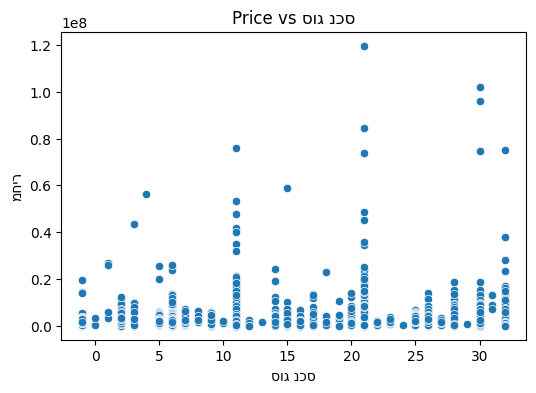

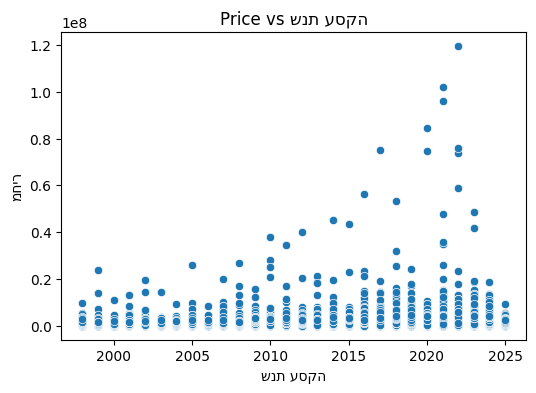

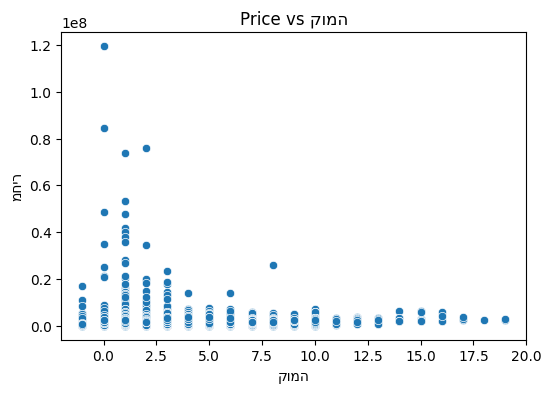

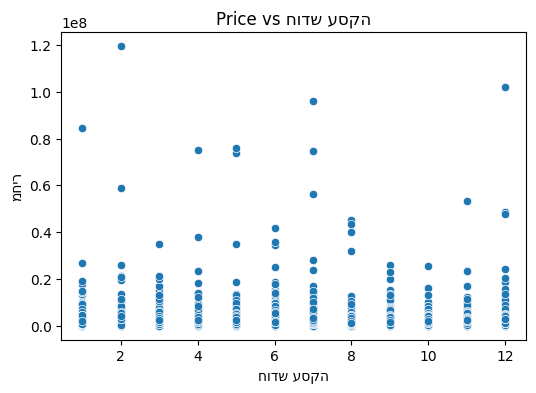

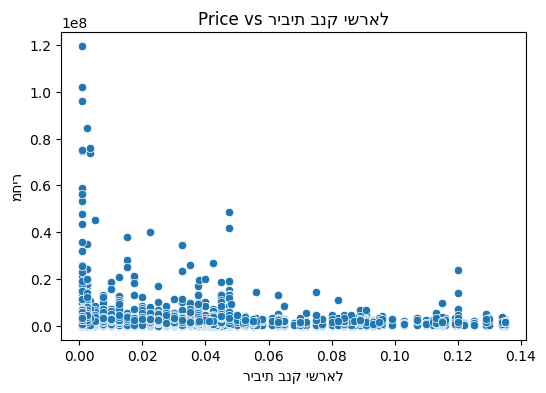

In [182]:
top_features = correlations.index[1:6]  # skip 'מחיר' itself

for feature in top_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feature, y='מחיר', data=pd.concat([X, y], axis=1))
    plt.title(f"Price vs {feature}")
    plt.show()

## Outlier Detection and Handling

In [183]:
# Detect outliers in target using IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Filter out outliers
mask = (y >= lower_bound) & (y <= upper_bound)
X_clean = X[mask]
y_clean = y[mask]

print(f"Removed {len(y) - len(y_clean)} outliers")

Lower bound: -832500.0, Upper bound: 2931500.0
Removed 2083 outliers


## Normalization of Features

In [184]:
# For simplicity we will normalize all numeric features except year/month which are ordinal
numeric_features = X_clean.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X_scaled = X_clean.copy()
X_scaled[numeric_features] = scaler.fit_transform(X_clean[numeric_features])

X_scaled.head()

,"מ""ר",גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,10920-100-27,6,3,0.445267,1960.0,5.0,17,0.695344,חטיבת כרמלי,21,2025,4
1,59.4,10920-100-27,6,3,0.445267,1960.0,5.0,17,-0.750780,חטיבת כרמלי,21,2018,12
2,68,12485-15-6,6,3,NaN,1940.0,3.0,17,0.695344,יד לבנים,7,2025,4
3,44.8,12482-19-9,6,2,-0.764593,1960.0,3.0,17,0.695344,יד לבנים,37,2025,3
4,54,10925-216-9,6,3,0.041980,2015.0,8.0,17,0.695344,נווה גנים,4,2025,3


## Train-Test Split

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clean, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (34480, 13)
Test shape: (8621, 13)
